In [1]:
from typing import List, Dict, Union

import simpy
import pandas as pd
import pybamm
import numpy as np
import matplotlib.pyplot as plt

pybamm.set_logging_level("INFO")

In [12]:
class PybammBattery:

    def __init__(self, env, capacity, soc=0, Vmin=2.8, Vmax=4.5):
        self.env = env
        self.capacity = capacity
        self.soc = soc
        self.excess_power = 0
        self.Vmin = Vmin
        self.Vmax = Vmax
        self.c_n_min = 0
        self.c_n_max = 0
        self.c_p_min = 0
        self.c_p_max = 0
        self.step_solution = None
        self.neg_soc = []
        self.pos_soc = []
        
        # load solver
        self.solver = pybamm.CasadiSolver()
        
        # load model
        self.model = pybamm.lithium_ion.SPMe()
        
        # load parameter values and process model and geometry
        self.parameter_values = pybamm.ParameterValues('Marquis2019')
        
        geometry = self.model.default_geometry
        self.parameter_values['Current function [A]'] = "[input]"
        self.parameter_values.process_model(self.model)
        self.parameter_values.process_geometry(geometry)
        
        # set mesh
        mesh = pybamm.Mesh(geometry, self.model.default_submesh_types, self.model.default_var_pts)

        # discretise model
        disc = pybamm.Discretisation(mesh, self.model.default_spatial_methods)
        disc.process_model(self.model)
            
        
    def update(self, current):
        if current == 0:
            return 0
        
        if self.step_solution is not None:
            print('condition final time: ', not (
            self.step_solution.termination == "final time"
            or "[experiment]" in self.step_solution.termination
        ))
        
        input_parameters= {}
        input_parameters['Current function [A]'] = current
        self.step_solution = self.solver.step(self.step_solution, self.model, dt=60, npts=100, inputs=input_parameters)
        
        self.calculate_soc()
        
        
    def calculate_soc(self):
        print('negative electrode: ', self.step_solution['Negative electrode SOC'].data[-1])
        print('positive electrode: ', self.step_solution['Positive electrode SOC'].data[-1])
        print('Discharge capacity: ', self.step_solution['Discharge capacity [A.h]'].data[-1])
        
        self.neg_soc.append(self.step_solution['Negative electrode SOC'].data[-1])
        self.pos_soc.append(self.step_solution['Positive electrode SOC'].data[-1])

In [13]:
def simulate(env: simpy.Environment, battery: PybammBattery, current_delta_list: List[float], records: List[Dict]):
    
    for current_delta in current_delta_list:
        yield env.timeout(1)
        battery.update(current_delta)
        records.append({
            "power_delta": current_delta,
            "excess_power": battery.excess_power,
            "soc": battery.soc,
            "capacity [A.h]": battery.capacity
        })

In [14]:
# For now let's assume the simple case of one step every second where we first (dis)charge and then implicitly read.
# Later we can extend this to a more asynchronous charge/discharge/read pattern with different processes if we want
current_delta_list = [1, -0.52, 0.069, 1, -1, -0.65]
records = []  # log of some infos for later analysis

env = simpy.Environment()
battery = PybammBattery(env, capacity=5)
env.process(simulate(env, battery, current_delta_list, records))
env.run()

result = pd.DataFrame(records)
with open("result.csv", "w") as f:
    f.write(result.to_csv())
print(result)

2022-04-28 17:11:40,597 - [INFO] base_battery_model.build_model(834): Start building Single Particle Model with electrolyte
2022-04-28 17:11:40,665 - [INFO] base_battery_model.build_model(854): Finish building Single Particle Model with electrolyte
2022-04-28 17:11:40,687 - [INFO] parameter_values.process_model(415): Start setting parameters for Single Particle Model with electrolyte
2022-04-28 17:11:40,791 - [INFO] parameter_values.process_model(518): Finish setting parameters for Single Particle Model with electrolyte
2022-04-28 17:11:40,793 - [INFO] discretisation.process_model(137): Start discretising Single Particle Model with electrolyte
2022-04-28 17:11:41,039 - [INFO] discretisation.process_model(254): Finish discretising Single Particle Model with electrolyte
2022-04-28 17:11:41,041 - [INFO] base_solver.set_up(111): Start solver set-up
2022-04-28 17:11:41,232 - [INFO] base_solver.set_up(678): Finish solver set-up


negative electrode:  0.7853715386382283
positive electrode:  0.6085626274993166
Discharge capacity:  0.01666666666666667
condition final time:  False
negative electrode:  0.7929783385463505
positive electrode:  0.604110061199672
Discharge capacity:  0.008000000000000004
condition final time:  False
negative electrode:  0.7919689747123879
positive electrode:  0.6047008824971251
Discharge capacity:  0.009150000000000007
condition final time:  False
negative electrode:  0.7773405133506147
positive electrode:  0.6132635099964417
Discharge capacity:  0.025816666666666686
condition final time:  False
negative electrode:  0.791968974712388
positive electrode:  0.604700882497125
Discharge capacity:  0.00915
condition final time:  False
negative electrode:  0.8014774745975407
positive electrode:  0.5991351746225693
Discharge capacity:  -0.001683333333333331
   power_delta  excess_power  soc  capacity [A.h]
0        1.000             0    0               5
1       -0.520             0    0      

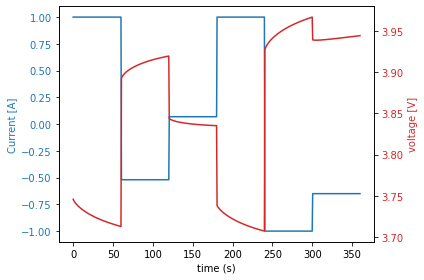

In [15]:
current = battery.step_solution['Current [A]'].entries
terminal_voltage = battery.step_solution['Terminal voltage [V]'].entries
step_time_in_seconds = battery.step_solution["Time [s]"].entries

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('Current [A]', color=color)
ax1.plot(step_time_in_seconds, current, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('voltage [V]', color=color)  # we already handled the x-label with ax1
ax2.plot(step_time_in_seconds, terminal_voltage, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

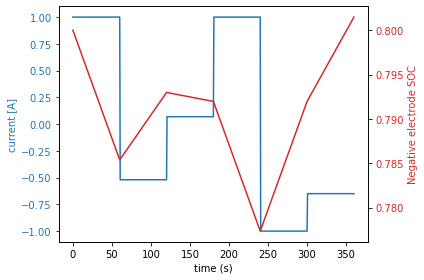

In [16]:
neg_soc = battery.step_solution['Negative electrode SOC'].entries
pos_soc = battery.step_solution['Positive electrode SOC'].entries
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('current [A]', color=color)
ax1.plot(step_time_in_seconds, current, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Negative electrode SOC', color=color)  # we already handled the x-label with ax1
ax2.plot(step_time_in_seconds, neg_soc, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()